In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.io import loadmat
import warnings
from tqdm import tqdm

from sklearn.dummy import DummyClassifier
from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_val_score, cross_val_predict
import sklearn
from sklearn.linear_model import LogisticRegressionCV
from sklearn.preprocessing import normalize, StandardScaler
from sklearn.metrics import f1_score, roc_curve
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier

import xgboost

warnings.filterwarnings('ignore')
plt.style.use('seaborn')

## Loading data

In [2]:
#Convert Personality to DataFrame
personality = loadmat('data/Dt_Personality.mat')
personality = personality['Personality']
big5 = pd.DataFrame(personality, columns=['extro', 'agree', 'cons', 'stability', 'open'])
#big5.head()

In [3]:
#Load MATLAB file for ECG"
ECG = loadmat('data/Dt_ECGFeatures.mat')
ECG_feats_mat = ECG['ECGFeatures_58']

In [4]:
def unfold_mat(mat, feats=None):
    #Returns list with each index being participant.
    #Each item has dataframe with shape video x feature (row is video, columns are features)
    lst = []
    for i in mat:
        d = pd.DataFrame(i, columns=feats)
        d.index += 1
        lst.append(d)
    
    return lst

def statistical_measurements(suffix):
    #Some modalities have statistical measurements, they are always the same 6 items.
    cols = []
    names = ['mean', 'std', 'skewness', 'kurtosis', '%time_over_mean+std', '%time_over_mean-std']
    for i in range(6):
        cols.append(names[i]+'_'+suffix)
    return cols

In [5]:
#Isolate ECG (Heart Monitor) Features
ECG_cols = ['low_freq_PSD' for x in range(10)]
[ECG_cols.append('slow_response_PSD') for x in range(4)]
[ECG_cols.append(x) for x in statistical_measurements('IBI')]
[ECG_cols.append(x) for x in statistical_measurements('HR')]
[ECG_cols.append(x) for x in statistical_measurements('HRV')]

ECG_feats = unfold_mat(ECG_feats_mat[0], feats=ECG_cols)

#Remove columns, where all rows are 0.0 or NaN - ECG had a lot of useless readings.
for i in range(len(ECG_feats)):
    ECG_feats[i] = ECG_feats[i].drop('low_freq_PSD', axis=1)
    ECG_feats[i] = ECG_feats[i].drop('slow_response_PSD', axis=1)
    ECG_feats[i] = ECG_feats[i].drop('mean_IBI', axis=1)
    ECG_feats[i] = ECG_feats[i].drop('std_IBI', axis=1)
    ECG_feats[i] = ECG_feats[i].drop('skewness_IBI', axis=1)
    ECG_feats[i] = ECG_feats[i].drop('kurtosis_IBI', axis=1)
    

#ECG_feats[0].head()

In [6]:
#Load EEG features
EEG = loadmat('data/Dt_EEGFeatures.mat')
EEG_feats_mat = EEG['EEGFeatures_58']

#Isolate EEG features
EEG_cols = []
[EEG_cols.append(x) for x in ['avg_first_deriv', 'prop_neg_diff_samples', 'mean_num_peaks', 'mean_deriv_inv_signal', 'avg_num_peaks_inv_signal']]
[EEG_cols.append(x) for x in statistical_measurements('EEG')]
[EEG_cols.append('attention') for x in range(11)]
[EEG_cols.append('meditation') for x in range(11)]
[EEG_cols.append('alpha') for x in range(11)]
[EEG_cols.append('beta') for x in range(11)]
[EEG_cols.append('delta') for x in range(11)]
[EEG_cols.append('gamma') for x in range(11)]
[EEG_cols.append('theta') for x in range(11)]

EEG_feats = unfold_mat(EEG_feats_mat[0], feats=EEG_cols)
#EEG_feats[0].head()

In [7]:
#Load GSR features
GSR = loadmat('data/Dt_GSRFeatures.mat')
GSR_feats_mat = GSR['GSRFeatures_58']
GSR_fails_mat = GSR['GSRFailures_58']

GSR_cols = ['mean_resistance',
            'mean_derivative',
            'mean_differential_neg_values',
            'proportion_neg_derivative_samples',
            'num_local_signal_minima',
            'avg_rising_time',
            'spectral_power_Hz',
            'zero_crossing_slow',
            'zero_crossing_very_slow',
            'mean_scsr',
            'scvsr_peak_mag']


GSR_feats = unfold_mat(GSR_feats_mat[0])
#GSR_feats[0].head()

In [8]:
#Load facial landmark features
EMO = loadmat('data/Dt_EMOFeatures.mat')
EMO_feats_mat = EMO['EMOFeatures_58']

EMO_cols = []
[EMO_cols.append(x) for x in statistical_measurements('verti_upper_lip')]
[EMO_cols.append(x) for x in statistical_measurements('verti_lower_lip')]
[EMO_cols.append(x) for x in statistical_measurements('horis_left_lip')]
[EMO_cols.append(x) for x in statistical_measurements('verti_left_lip')]
[EMO_cols.append(x) for x in statistical_measurements('horis_right_lip')]
[EMO_cols.append(x) for x in statistical_measurements('verti_right_lip')]
[EMO_cols.append(x) for x in statistical_measurements('right_eyebrow')]
[EMO_cols.append(x) for x in statistical_measurements('left_eyebrow')]
[EMO_cols.append(x) for x in statistical_measurements('right_cheek')]
[EMO_cols.append(x) for x in statistical_measurements('left_cheek')]
[EMO_cols.append(x) for x in statistical_measurements('right_lid')]
[EMO_cols.append(x) for x in statistical_measurements('left_lid')]

EMO_feats = unfold_mat(EMO_feats_mat[0], feats=EMO_cols)
#EMO_feats[0].head()

### Feature Early Fusion

In [25]:
FUS_feats = []
PHY_feats = []

for i in range(len(GSR_feats)):
    args_FUS = (ECG_feats[i], EEG_feats[i], GSR_feats[i], EMO_feats[i])
    args_PHY = (ECG_feats[i], EEG_feats[i], GSR_feats[i])
    fused = pd.concat(args_FUS, axis=1)
    phys = pd.concat(args_PHY, axis=1)
    
    FUS_feats.append(fused)
    PHY_feats.append(phys)
    

FUS_feats[1].head(10)

,%time_over_mean+std_IBI,%time_over_mean-std_IBI,mean_HR,std_HR,skewness_HR,kurtosis_HR,%time_over_mean+std_HR,%time_over_mean-std_HR,mean_HRV,std_HRV,...,skewness_right_lid,kurtosis_right_lid,%time_over_mean+std_right_lid,%time_over_mean-std_right_lid,mean_left_lid,std_left_lid,skewness_left_lid,kurtosis_left_lid,%time_over_mean+std_left_lid,%time_over_mean-std_left_lid
1,-3.223879,-0.894268,-2.459274,-1.888241,-4.907992,-2.459274,-3.320632,-2.846179,-3.400089,-3.097779,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,-3.011830,-1.960795,-2.799002,-1.405364,-4.341853,-2.799002,-3.790695,-2.343931,-3.298362,-3.492356,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,-3.689150,-1.829840,-2.623891,-1.777783,-6.138974,-2.623891,-2.738031,-2.686062,-3.396331,-2.873831,...,-1.125112,14.301098,0.028,0.076,0.067627,0.225116,3.049129,12.015081,0.096,0.007
4,-2.846071,-1.815426,-2.647436,-1.819482,-4.100201,-2.647436,-3.803400,-3.520561,-3.491913,-2.724038,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,4.164638,5.805220,5.343113,5.968571,2.188647,5.343113,4.920622,3.942144,2.214400,-0.611225,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,-0.130335,1.108418,0.362486,1.374244,-1.147365,0.362486,0.533230,-0.006560,-0.480327,-1.178915,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,-3.194035,-1.463456,-2.815140,-2.228710,-4.385257,-2.815140,-3.518724,-2.741814,-4.225034,-2.882799,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,7.569535,4.665613,4.871935,5.770077,7.724229,4.871935,4.207737,4.231280,2.693989,2.588662,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,-3.110532,-1.751896,-2.418234,-1.734164,-3.816802,-2.418234,-3.897499,-3.039663,-3.985266,-2.601276,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10,-3.639539,-1.748988,-2.644427,-2.123427,-4.212205,-2.644427,-4.360888,-3.011677,-3.936302,-3.113027,...,4.332981,23.627444,0.073,0.005,0.003832,0.156788,1.660432,22.770193,0.036,0.040


## Data preprocessing

In [10]:
def get_group(modality, group):
    #Returns a subset of modality after grouped movie clip
    #ex: get_group(EEG_feats, LAHV) -> list with dataframes, each is a participant, each row movie
    out = []
    for i in range(len(modality)):
        out.append(modality[i].loc[group])
    return out

def trait_binary(trait):
    #Converts personality trait to 0/1 (low/high) depending on median.
    #Returns a 1D numpy array
    median = np.median(big5.loc[:][trait].values)
    mask = big5.loc[:][trait]>median
    return mask.astype(int).values
    

def format_train_data(modality, trait, shuffle=False):
    #Creates input vectors and output vectors for modality and trait combination.
    vector_x = []
    vector_y = []
    
    bool5 = trait_binary(trait)
    
    for i, participant in enumerate(modality):
        participant.replace([np.inf, -np.inf], np.nan, inplace=True)
        participant = participant.dropna()
        y = bool5[i]
        
        for clip in participant.index:
            vector_x.append(participant.loc[clip].values)
            vector_y.append(y)
    
    vector_y = np.array(vector_y)
    vector_x = np.array(vector_x)
    if shuffle:
        vector_x, vector_y = sklearn.utils.shuffle(vector_x, vector_y, random_state=42)
        
    return vector_x, vector_y

def preprocess(features, target_trait):
    #Function, which returns standardized PCA on X and y
    pca = PCA(n_components=0.99)
    X, y = format_train_data(features, target_trait, shuffle=True)
    scaler = StandardScaler().fit(X)
    X = scaler.transform(X)

    x_pca = pca.fit_transform(X)
    
    return x_pca, y

def results(classifier):
    #Creates dataframe with unimodal results.
    mats = { #Dict with column names corresponding to features.
        'EEG': EEG_feats,
        'ECG': ECG_feats,
        'EMO': EMO_feats,
        'GSR': GSR_feats
    }
    scores = []
    all_targets = []
    all_preds = []
    #Initialise dataframe
    df = pd.DataFrame(columns=big5.keys(), index=['ECG', 'EEG', 'GSR', 'EMO'])
    for trait in tqdm(list(df.keys())):
        for modal in list(df.index):
            #For each combination of modality and trait:
            X, y = preprocess(mats[modal], trait) #
            score = round(np.mean(cross_val_score(classifier, X, y, scoring='f1', cv=10)),2)
            df[trait][modal] = score
            scores.append(score)
            all_targets.append(y)
            all_preds.append(cross_val_predict(classifier, X, y, cv=10, method='predict_proba'))

    print("Mean score:", np.mean(scores))
    print("STD score:", np.std(scores))
    
    return df, (np.array(all_targets), np.array(all_preds))

In [27]:
def results_mod(classifier):
    #Creates dataframe with unimodal results.
    mats = { #Dict with column names corresponding to features.
        'EEG': EEG_feats,
        'ECG': ECG_feats,
        'EMO': EMO_feats,
        'GSR': GSR_feats,
        'PHY': PHY_feats,
        'FUS': FUS_feats
    }
    scores = []
    all_targets = []
    all_preds = []
    #Initialise dataframe
    df = pd.DataFrame(columns=big5.keys(), index=['ECG', 'EEG', 'GSR', 'EMO', 'PHY', 'FUS'])
    for trait in tqdm(list(df.keys())):
        for modal in list(df.index):
            #For each combination of modality and trait:
            X, y = preprocess(mats[modal], trait) #
            score = round(np.mean(cross_val_score(classifier, X, y, scoring='f1', cv=10)),2)
            df[trait][modal] = score
            scores.append(score)
            all_targets.append(y)
            all_preds.append(cross_val_predict(classifier, X, y, cv=10, method='predict_proba'))

    print("Mean score:", np.mean(scores))
    print("STD score:", np.std(scores))
    
    return df, (np.array(all_targets), np.array(all_preds))

## Models

### Logistic Regression

In [29]:
warnings.filterwarnings('ignore') #uncomment to turn on warnings
logreg = LogisticRegressionCV(random_state=42, max_iter=2500, scoring='f1', n_jobs=4)
df, log_targs = results(logreg)
df

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:42<00:00,  8.58s/it]

Mean score: 0.544
STD score: 0.09911609354691095


,extro,agree,cons,stability,open
ECG,0.63,0.52,0.56,0.62,0.48
EEG,0.63,0.42,0.48,0.64,0.43
GSR,0.57,0.49,0.49,0.59,0.25
EMO,0.66,0.66,0.62,0.56,0.58


In [30]:
warnings.filterwarnings('ignore') #uncomment to turn on warnings
logreg = LogisticRegressionCV(random_state=42, max_iter=2500, scoring='f1', n_jobs=4)
df, log_targs = results_mod(logreg)
df

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:21<00:00, 28.37s/it]

Mean score: 0.5806666666666668
STD score: 0.10366398710363317


,extro,agree,cons,stability,open
ECG,0.63,0.52,0.56,0.62,0.48
EEG,0.63,0.42,0.48,0.64,0.43
GSR,0.57,0.49,0.49,0.59,0.25
EMO,0.66,0.66,0.62,0.56,0.58
PHY,0.66,0.53,0.58,0.68,0.57
FUS,0.74,0.72,0.67,0.72,0.67


### Random Forest Classifier

In [12]:
rfc = RandomForestClassifier(n_estimators=500, n_jobs=4, random_state=42)
df, rf_targs = results(rfc)
df

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [06:20<00:00, 76.17s/it]

Mean score: 0.612
STD score: 0.11404385121522334


,extro,agree,cons,stability,open
ECG,0.72,0.72,0.72,0.72,0.65
EEG,0.62,0.44,0.41,0.64,0.37
GSR,0.59,0.54,0.58,0.61,0.43
EMO,0.76,0.71,0.69,0.67,0.65


### Multi-Layer Perceptron 

In [13]:
# solver='lbfgs' is supposed to be used for small datasets, but i get better results using the default 'adam'

mlp = MLPClassifier(random_state=42, max_iter=2000)
df, mlp_targs = results(mlp)
df

100%|███████████████████████████████████████████████████████████████████████████████████| 5/5 [33:50<00:00, 406.13s/it]

Mean score: 0.6475000000000002
STD score: 0.11058367872339932


,extro,agree,cons,stability,open
ECG,0.73,0.71,0.72,0.72,0.65
EEG,0.56,0.52,0.52,0.62,0.47
GSR,0.59,0.56,0.58,0.61,0.46
EMO,0.82,0.81,0.76,0.77,0.77


In [15]:
mlp = MLPClassifier(hidden_layer_sizes = (30, 30), random_state=42, max_iter=2000)
df, mlp_targs = results(mlp)
df

100%|███████████████████████████████████████████████████████████████████████████████████| 5/5 [21:44<00:00, 260.94s/it]

Mean score: 0.6395000000000002
STD score: 0.10423411149906732


,extro,agree,cons,stability,open
ECG,0.73,0.73,0.72,0.73,0.64
EEG,0.55,0.53,0.52,0.59,0.46
GSR,0.6,0.55,0.57,0.59,0.48
EMO,0.79,0.78,0.73,0.75,0.75


### Decision Fusion

In [14]:
#Decision fusion

#ECG
a_ecg = model_weights_ecg #stand-in for actual weights
p_ecg = model_post_prob_ecg #stand-in for posterior prob

#EEG
a_eeg = model_weights _eeg
p_eeg = model.model_post_prob_eeg

#GSR
a_gsr = model_weights_gsr 
p_gsr = model_post_prob_gsr

#EMO
a_emo = model_weights_emo 
p_emo = model_post_prob_emo


t_ecg = (a_ecg * f1_ecg) / (a_ecg * f1_ecg) + (a_eeg * f1_eeg) + (a_gsr * f1_gsr) + (a_emo * f1_emo)
t_eeg = (a_eeg * f1_eeg) / (a_ecg * f1_ecg) + (a_eeg * f1_eeg) + (a_gsr * f1_gsr) + (a_emo * f1_emo)
t_gsr = (a_gsr * f1_gsr) / (a_ecg * f1_ecg) + (a_eeg * f1_eeg) + (a_gsr * f1_gsr) + (a_emo * f1_emo)
t_emo = (a_emo * f1_emo) / (a_ecg * f1_ecg) + (a_eeg * f1_eeg) + (a_gsr * f1_gsr) + (a_emo * f1_emo)

df_ecg = a_ecg * (t_ecg * p_ecg)
df_eeg = a_eeg * (t_eeg * p_eeg)
df_ecg = a_gsr * (t_gsr * p_gsr)
df_ecg = a_emo * (t_ecg * p_emo)

result_df = df_ecg + df_eeg + df_gsr + df_emo

SyntaxError: invalid syntax (<ipython-input-14-8ba32d4fb9f8>, line 8)

## Plotting results

### ROC Curve

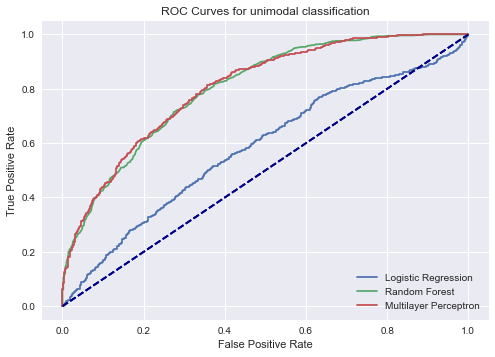

In [16]:
def plot_roc_cur(fper, tper, label="", title="plot title"):
    plt.plot(fper, tper, label=label)
    plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(title)
    plt.legend(loc='lower right')
    
def create_roc_curve(preds, targets, label="", title=""):
    all_fpr, all_tpr = [], []
    fpr, tpr, thresholds = roc_curve(preds[0], targets[0][:,1])
    all_fpr.append(fpr)
    all_tpr.append(tpr)
    all_fpr = np.array(all_fpr)
    all_tpr = np.array(tpr)
    
    plot_roc_cur(all_fpr[0], all_tpr, label=label, title=title)
    
create_roc_curve(log_targs[0], log_targs[1], label="Logistic Regression")
create_roc_curve(rf_targs[0], rf_targs[1], label="Random Forest")
create_roc_curve(mlp_targs[0], mlp_targs[1], label="Multilayer Perceptron", title="ROC Curves for unimodal classification")

### PCA Plot

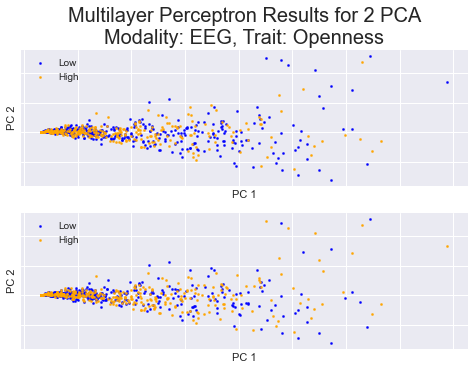

In [17]:
def plot_pcs(pcs, target, labels, ctitle=""):   
    group1 = pcs[target==0]
    group2 = pcs[target==1]
    
    
    plt.scatter(group1[:,0], group1[:,1], label=labels[0], s=5, c='blue')
    plt.scatter(group2[:,0], group2[:,1], label=labels[1], s=5, c='orange')
    
    plt.xlabel("PC 1")
    plt.ylabel("PC 2")
    
    plt.tick_params(left=False,
                bottom=False,
                labelleft=False,
                labelbottom=False)
    plt.legend()


#Nogle kombinationer giver fejl, men synes ikke, vi skal bruge tid på dem...
def make_pca_plot(targs, modal, trait, title="Placeholder Title"):
    traits = ['extro', 'agree', 'cons', 'stability', 'open']
    modals = ['ECG', 'EEG', 'GSR', 'EMO']
    modal_dict = {
        'ECG': ECG_feats,
        'EEG': EEG_feats,
        'GSR': GSR_feats,
        'EMO': EMO_feats,
    }
    index = 0
    for i in modals: #Convert string combination to index
        for j in traits:
            if i == modal and j == trait:
                break
            index += 1  
        if i == modal and j == trait:
            break
    
    targets = targs[0][index]
    predictions = targs[1][index]>0.5
    predictions = predictions.astype(int)[:,1]
    
    pca = PCA(n_components=2)
    X,y = format_train_data(modal_dict[modal], trait)
    pcs = pca.fit_transform(X)
    
    #Plot true labels
    fig = plt.figure()
    plt.tick_params(left=False,
                bottom=False,
                labelleft=False,
                labelbottom=False)
    ax = fig.add_subplot(1,1,1)
    ax.grid(False)
    ax.set_facecolor('white')
    ax1 = fig.add_subplot(2, 1, 1)
    plot_pcs(pcs, predictions, ("Low", "High"))
    ax2 = fig.add_subplot(2, 1, 2)
    plot_pcs(pcs, y, ("Low", "High"))
    ax.set_title(title, fontsize=20)
    

make_pca_plot(mlp_targs, 'EEG', 'open', title="Multilayer Perceptron Results for 2 PCA\nModality: EEG, Trait: Openness")

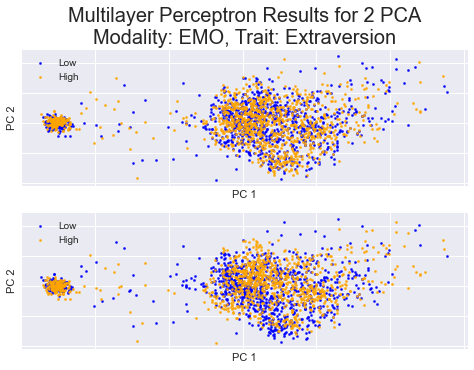

In [18]:
make_pca_plot(mlp_targs, 'ECG', 'extro', title="Multilayer Perceptron Results for 2 PCA\nModality: EMO, Trait: Extraversion")

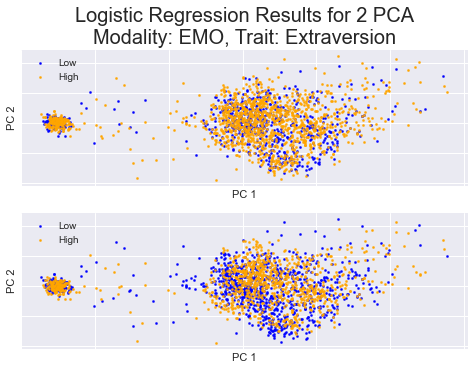

In [19]:
make_pca_plot(log_targs, 'ECG', 'extro', title="Logistic Regression Results for 2 PCA\nModality: EMO, Trait: Extraversion")

In [20]:
#14 - stab gsr
14%5
14%4
mask = big5.loc[:][trait]>median
    return mask.astype(int).values

IndentationError: unexpected indent (<ipython-input-20-92a9aa3cd21a>, line 5)

In [21]:
t = mlp_targs[1][0]>0.5
t.astype(int)

array([[0, 1],
       [1, 0],
       [1, 0],
       ...,
       [0, 1],
       [0, 1],
       [1, 0]])